In [1]:
# Cell 1: Imports and Constants
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- Constants ---
CLEANED_DATA_DIR = os.path.expanduser('~/Repos/cat-classification/data/cleaned-data/cat-breeds-cleaned')
PROCESSED_DATA_DIR = os.path.expanduser('~/Repos/cat-classification/data/processed')

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15 # 1.0 - TRAIN_RATIO - VAL_RATIO

# Ensure ratios sum to 1 (approximately, due to potential float precision)
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9, "Ratios must sum to 1.0"

RANDOM_SEED = 42 # For reproducibility


In [2]:
# Cell 2: Load cleaned image paths and labels
image_paths = []
labels = []

if not os.path.exists(CLEANED_DATA_DIR):
    print(f"Lỗi: Thư mục dữ liệu đã làm sạch không tìm thấy tại: {CLEANED_DATA_DIR}")
    # Dừng thực thi nếu thư mục không tồn tại
    raise FileNotFoundError(f"Thư mục dữ liệu đã làm sạch không tìm thấy tại: {CLEANED_DATA_DIR}")
else:
    print(f"Đang tải ảnh từ: {CLEANED_DATA_DIR}")
    breed_names = sorted([d for d in os.listdir(CLEANED_DATA_DIR) if os.path.isdir(os.path.join(CLEANED_DATA_DIR, d))])
    
    for breed_name in breed_names:
        breed_dir = os.path.join(CLEANED_DATA_DIR, breed_name)
        # Sử dụng glob để tìm tất cả các tệp ảnh phổ biến, không phân biệt chữ hoa chữ thường cho phần mở rộng
        current_breed_images = []
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp'):
            current_breed_images.extend(glob.glob(os.path.join(breed_dir, ext)))
            current_breed_images.extend(glob.glob(os.path.join(breed_dir, ext.upper()))) # Cho phần mở rộng viết hoa

        # Loại bỏ các đường dẫn trùng lặp nếu có do tìm kiếm cả chữ hoa và chữ thường
        current_breed_images = sorted(list(set(current_breed_images)))

        image_paths.extend(current_breed_images)
        labels.extend([breed_name] * len(current_breed_images))
        print(f"  Tìm thấy {len(current_breed_images)} ảnh cho giống: {breed_name}")

    print(f"\nTổng số ảnh tìm thấy: {len(image_paths)}")
    print(f"Tổng số nhãn (giống mèo): {len(labels)}")
    if image_paths:
        print(f"Ví dụ đường dẫn ảnh: {image_paths[0]}")
        print(f"Ví dụ nhãn: {labels[0]}")
    else:
        print("Không tìm thấy ảnh nào. Vui lòng kiểm tra lại thư mục CLEANED_DATA_DIR.")

# Chuyển đổi thành numpy array để dễ xử lý hơn với sklearn
image_paths = np.array(image_paths)
labels = np.array(labels)

Đang tải ảnh từ: /home/maidang/Repos/cat-classification/data/cleaned-data/cat-breeds-cleaned
  Tìm thấy 200 ảnh cho giống: abyssinian
  Tìm thấy 140 ảnh cho giống: american_bobtail
  Tìm thấy 138 ảnh cho giống: american_curl
  Tìm thấy 199 ảnh cho giống: american_shorthair
  Tìm thấy 196 ảnh cho giống: american_wirehair
  Tìm thấy 195 ảnh cho giống: balinese
  Tìm thấy 189 ảnh cho giống: bengal
  Tìm thấy 131 ảnh cho giống: birman
  Tìm thấy 154 ảnh cho giống: bombay
  Tìm thấy 174 ảnh cho giống: british_shorthair
  Tìm thấy 197 ảnh cho giống: burmese
  Tìm thấy 114 ảnh cho giống: chartreux
  Tìm thấy 200 ảnh cho giống: chausie
  Tìm thấy 197 ảnh cho giống: cornish_rex
  Tìm thấy 198 ảnh cho giống: cymric
  Tìm thấy 200 ảnh cho giống: cyprus
  Tìm thấy 138 ảnh cho giống: devon_rex
  Tìm thấy 200 ảnh cho giống: donskoy
  Tìm thấy 184 ảnh cho giống: egyptian_mau
  Tìm thấy 200 ảnh cho giống: european_shorthair
  Tìm thấy 157 ảnh cho giống: exotic_shorthair
  Tìm thấy 199 ảnh cho giống: g

In [3]:
# Cell 3: Split into train/val/test (stratified)
if len(image_paths) == 0:
    print("Không có dữ liệu để chia. Bỏ qua bước chia.")
else:
    # Đầu tiên, chia thành tập huấn luyện và tập tạm thời (val + test)
    # Stratify by labels để đảm bảo phân phối đồng đều các giống mèo
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels,
        test_size=(VAL_RATIO + TEST_RATIO),
        random_state=RANDOM_SEED,
        stratify=labels
    )

    # Bây giờ, chia tập tạm thời thành tập validation và tập test
    # Tính toán tỷ lệ test so với kích thước của tập tạm thời
    relative_test_ratio = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
    
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=relative_test_ratio,
        random_state=RANDOM_SEED,
        stratify=temp_labels # Stratify trên tập tạm thời
    )

    print(f"Kích thước tập huấn luyện (train): {len(train_paths)} ảnh")
    print(f"Kích thước tập validation (val): {len(val_paths)} ảnh")
    print(f"Kích thước tập kiểm tra (test): {len(test_paths)} ảnh")

    # Kiểm tra phân phối nhãn (tùy chọn)
    print("\nPhân phối số lượng mẫu theo giống trong mỗi tập (5 giống đầu tiên):")
    for name, paths, path_labels in [("Train", train_paths, train_labels), ("Val", val_paths, val_labels), ("Test", test_paths, test_labels)]:
        unique_labels, counts = np.unique(path_labels, return_counts=True)
        print(f" {name}:")
        for l, c in list(zip(unique_labels, counts))[:5]:
            print(f"    {l}: {c}")

Kích thước tập huấn luyện (train): 7898 ảnh
Kích thước tập validation (val): 1693 ảnh
Kích thước tập kiểm tra (test): 1693 ảnh

Phân phối số lượng mẫu theo giống trong mỗi tập (5 giống đầu tiên):
 Train:
    abyssinian: 140
    american_bobtail: 98
    american_curl: 97
    american_shorthair: 139
    american_wirehair: 137
 Val:
    abyssinian: 30
    american_bobtail: 21
    american_curl: 20
    american_shorthair: 30
    american_wirehair: 30
 Test:
    abyssinian: 30
    american_bobtail: 21
    american_curl: 21
    american_shorthair: 30
    american_wirehair: 29


In [4]:
# Cell 4: Create folder structure and copy images

def create_dirs_and_copy_files(dataset_paths, dataset_labels, set_name):
    """
    Tạo cấu trúc thư mục và sao chép các tệp ảnh.
    set_name: 'train', 'val', hoặc 'test'
    """
    print(f"\nĐang tạo thư mục và sao chép ảnh cho tập: {set_name}")
    set_dir = os.path.join(PROCESSED_DATA_DIR, set_name)
    
    # Xóa thư mục nếu đã tồn tại để tránh lỗi hoặc dữ liệu cũ
    if os.path.exists(set_dir):
        print(f"  Thư mục {set_dir} đã tồn tại. Xóa thư mục cũ...")
        shutil.rmtree(set_dir) # Cẩn thận với lệnh này!
    os.makedirs(set_dir, exist_ok=True)

    copied_count = 0
    for img_path, label in zip(dataset_paths, dataset_labels):
        breed_specific_dir = os.path.join(set_dir, label)
        os.makedirs(breed_specific_dir, exist_ok=True)
        
        destination_path = os.path.join(breed_specific_dir, os.path.basename(img_path))
        try:
            shutil.copy2(img_path, destination_path)
            copied_count += 1
        except Exception as e:
            print(f"  Lỗi khi sao chép {img_path} sang {destination_path}: {e}")
            
    print(f"  Đã sao chép {copied_count} ảnh vào {set_dir}")

if len(image_paths) > 0:
    # Tạo thư mục processed chính nếu chưa có
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
    
    create_dirs_and_copy_files(train_paths, train_labels, 'train')
    create_dirs_and_copy_files(val_paths, val_labels, 'val')
    create_dirs_and_copy_files(test_paths, test_labels, 'test')
    print("\nHoàn tất việc tạo thư mục và sao chép ảnh.")
else:
    print("Không có dữ liệu để xử lý trong Cell 4.")


Đang tạo thư mục và sao chép ảnh cho tập: train
  Đã sao chép 7898 ảnh vào /home/maidang/Repos/cat-classification/data/processed/train

Đang tạo thư mục và sao chép ảnh cho tập: val
  Đã sao chép 1693 ảnh vào /home/maidang/Repos/cat-classification/data/processed/val

Đang tạo thư mục và sao chép ảnh cho tập: test
  Đã sao chép 1693 ảnh vào /home/maidang/Repos/cat-classification/data/processed/test

Hoàn tất việc tạo thư mục và sao chép ảnh.



Xem trước ảnh sau khi chia:


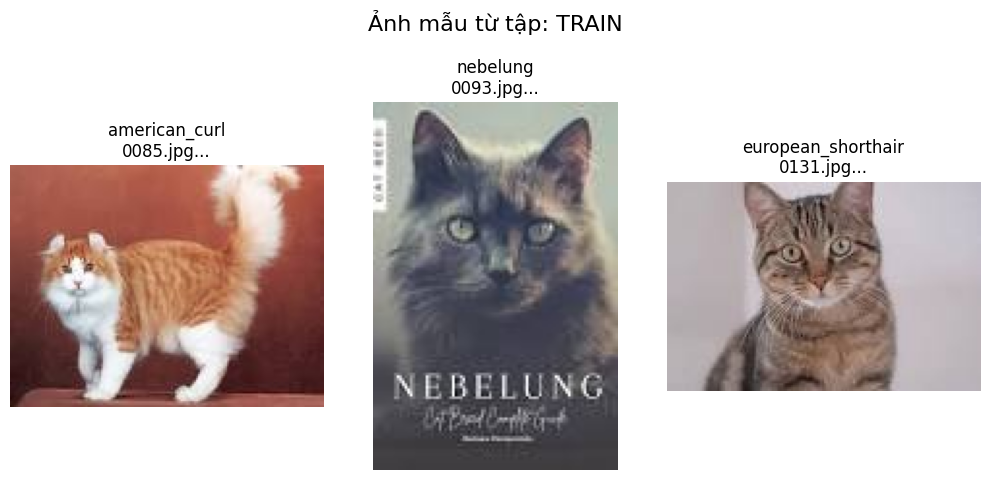

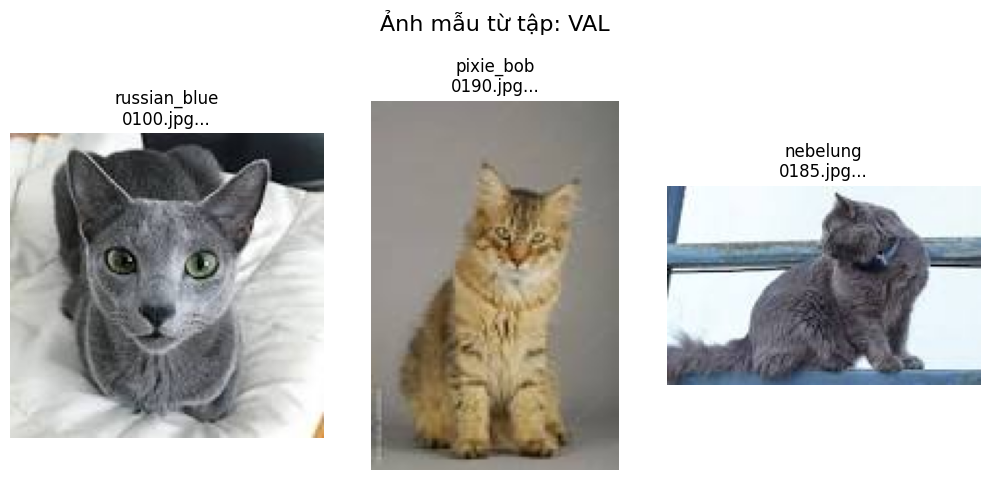

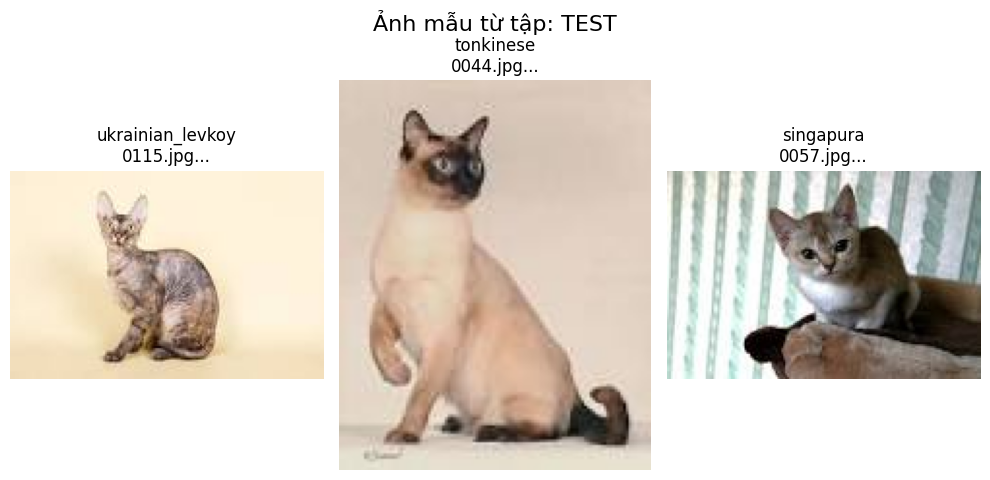

In [5]:
# Cell 5: (Optional) Preview images after splitting

def preview_images(base_dir, set_name, num_images=3):
    """Hiển thị một vài ảnh ngẫu nhiên từ một tập dữ liệu cụ thể."""
    set_path = os.path.join(base_dir, set_name)
    if not os.path.exists(set_path):
        print(f"Thư mục {set_path} không tồn tại.")
        return

    all_image_files = []
    for breed_folder in os.listdir(set_path):
        breed_folder_path = os.path.join(set_path, breed_folder)
        if os.path.isdir(breed_folder_path):
            for ext in ('*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp'):
                 all_image_files.extend(glob.glob(os.path.join(breed_folder_path, ext)))
                 all_image_files.extend(glob.glob(os.path.join(breed_folder_path, ext.upper())))
    
    all_image_files = sorted(list(set(all_image_files)))


    if not all_image_files:
        print(f"Không tìm thấy ảnh nào trong {set_path}")
        return

    random_images = random.sample(all_image_files, min(num_images, len(all_image_files)))

    plt.figure(figsize=(10, 4 * num_images // 3 if num_images > 3 else 5))
    plt.suptitle(f"Ảnh mẫu từ tập: {set_name.upper()}", fontsize=16)
    for i, img_path in enumerate(random_images):
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            breed = os.path.basename(os.path.dirname(img_path))
            plt.title(f"{breed}\n{os.path.basename(img_path)[:15]}...") # Hiển thị tên giống và tên tệp (rút gọn)
            plt.axis('off')
        except Exception as e:
            print(f"Lỗi khi mở ảnh {img_path}: {e}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề chính không bị chồng chéo
    plt.show()

if len(image_paths) > 0:
    print("\nXem trước ảnh sau khi chia:")
    preview_images(PROCESSED_DATA_DIR, 'train', num_images=3)
    preview_images(PROCESSED_DATA_DIR, 'val', num_images=3)
    preview_images(PROCESSED_DATA_DIR, 'test', num_images=3)
else:
    print("Không có dữ liệu để xem trước trong Cell 5.")